# Exploración de Datos - Versión Mejorada

Análisis conciso y accionable del dataset EXIST2025

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar datos
with open('../lab1_materials/dataset_task1_exist2025/training.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

df = pd.DataFrame(list(train_data.values()))
df['task1'] = df['labels_task1'].apply(lambda x: Counter(x).most_common(1)[0][0])
print(f"Muestras: {len(df)}\nClases: {df['task1'].value_counts()}")

Muestras: 6064
Clases: task1
NO     3367
YES    2697
Name: count, dtype: int64


## Análisis de Vocabulario

In [3]:
# Análisis de vocabulario por clase
def analyze_vocabulary(df, label_col='task1'):
    results = {}
    for label in df[label_col].unique():
        texts = df[df[label_col] == label]['tweet'].tolist()
        all_words = ' '.join(texts).lower().split()
        vocab = set(all_words)
        results[label] = {
            'vocab_size': len(vocab),
            'total_words': len(all_words),
            'unique_ratio': len(vocab) / len(all_words)
        }
    return pd.DataFrame(results).T

vocab_stats = analyze_vocabulary(df)
print("Estadísticas de vocabulario por clase:")
print(vocab_stats)

Estadísticas de vocabulario por clase:
     vocab_size  total_words  unique_ratio
YES     22198.0      76696.0      0.289428
NO      29449.0      94287.0      0.312334


## Palabras Discriminativas (Chi-square)

In [4]:
# Palabras más discriminativas usando chi-square
vectorizer = CountVectorizer(max_features=1000, min_df=5, lowercase=True)
X = vectorizer.fit_transform(df['tweet'])
y = (df['task1'] == 'YES').astype(int)

chi2_scores = []
for i in range(X.shape[1]):
    contingency = pd.crosstab(X[:, i].toarray().ravel(), y)
    chi2, p_value, _, _ = chi2_contingency(contingency)
    chi2_scores.append((vectorizer.get_feature_names_out()[i], chi2, p_value))

chi2_df = pd.DataFrame(chi2_scores, columns=['word', 'chi2', 'p_value']).sort_values('chi2', ascending=False)
print("\nTop 20 palabras discriminativas:")
print(chi2_df.head(20).to_string(index=False))


Top 20 palabras discriminativas:
     word       chi2      p_value
  mujeres 323.441380 9.485047e-69
    women 238.281755 2.175030e-50
    mujer 139.731910 3.221358e-29
      las 127.161637 9.522683e-26
       co 111.390689 3.675925e-23
    https 105.427043 6.868979e-22
      que  87.711100 3.648785e-16
      men  79.555304 3.823134e-17
   hombre  71.845383 1.718051e-15
feminismo  71.325276 2.220448e-15
      the  64.627177 5.718678e-11
       es  55.001710 3.246298e-11
       no  52.972133 1.188549e-09
 machista  45.396044 1.387951e-10
  hombres  44.345190 1.274705e-09
    woman  43.668667 7.517230e-09
   sexist  42.926195 4.771943e-10
       of  41.698796 5.942534e-07
    whore  38.868618 3.629000e-09
 feminazi  38.341962 5.937213e-10


## N-gramas Discriminativos

In [5]:
# Análisis de bigramas por clase
def get_top_ngrams(texts, n=2, top_k=15):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=500, min_df=3)
    X = vectorizer.fit_transform(texts)
    counts = X.sum(axis=0).A1
    ngrams = vectorizer.get_feature_names_out()
    return sorted(zip(ngrams, counts), key=lambda x: x[1], reverse=True)[:top_k]

for label in ['YES', 'NO']:
    texts = df[df['task1'] == label]['tweet'].tolist()
    bigrams = get_top_ngrams(texts, n=2, top_k=10)
    print(f"\nTop bigramas en clase {label}:")
    for ngram, count in bigrams:
        print(f"  {ngram}: {count}")


Top bigramas en clase YES:
  https co: 717
  las mujeres: 268
  de la: 202
  que no: 107
  lo que: 104
  de las: 95
  una mujer: 93
  mujeres no: 85
  de género: 84
  que se: 83

Top bigramas en clase NO:
  https co: 1386
  de la: 276
  en el: 151
  of the: 148
  en la: 127
  in the: 111
  de género: 99
  de los: 99
  que no: 97
  to be: 94


## Análisis de Patrones

In [6]:
# Análisis de patrones textuales
patterns = {
    'urls': r'http[s]?://\S+',
    'mentions': r'@\w+',
    'hashtags': r'#\w+',
    'exclamations': r'!+',
    'questions': r'\?+',
    'caps_words': r'\b[A-Z]{2,}\b'
}

for pattern_name, pattern in patterns.items():
    df[f'has_{pattern_name}'] = df['tweet'].str.contains(pattern, regex=True)

# Correlación de patrones con etiqueta
pattern_cols = [f'has_{p}' for p in patterns.keys()]
df['label_binary'] = (df['task1'] == 'YES').astype(int)

print("\nCorrelación de patrones con sexismo:")
for col in pattern_cols:
    corr = df[[col, 'label_binary']].corr().iloc[0, 1]
    print(f"  {col}: {corr:.4f}")


Correlación de patrones con sexismo:
  has_urls: -0.1245
  has_mentions: 0.0245
  has_hashtags: -0.1063
  has_exclamations: -0.0158
  has_questions: 0.0542
  has_caps_words: -0.0455


## Análisis de Longitud y Complejidad

In [7]:
# Features de complejidad
df['word_count'] = df['tweet'].str.split().str.len()
df['char_count'] = df['tweet'].str.len()
df['avg_word_len'] = df['char_count'] / df['word_count']
df['caps_ratio'] = df['tweet'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Comparar por clase
complexity_features = ['word_count', 'char_count', 'avg_word_len', 'caps_ratio']
print("\nEstadísticas por clase:")
print(df.groupby('task1')[complexity_features].mean())


Estadísticas por clase:
       word_count  char_count  avg_word_len  caps_ratio
task1                                                  
NO      28.003267  180.396495      6.667736    0.057085
YES     28.437523  174.014461      6.256382    0.047454


## Análisis de Agreement

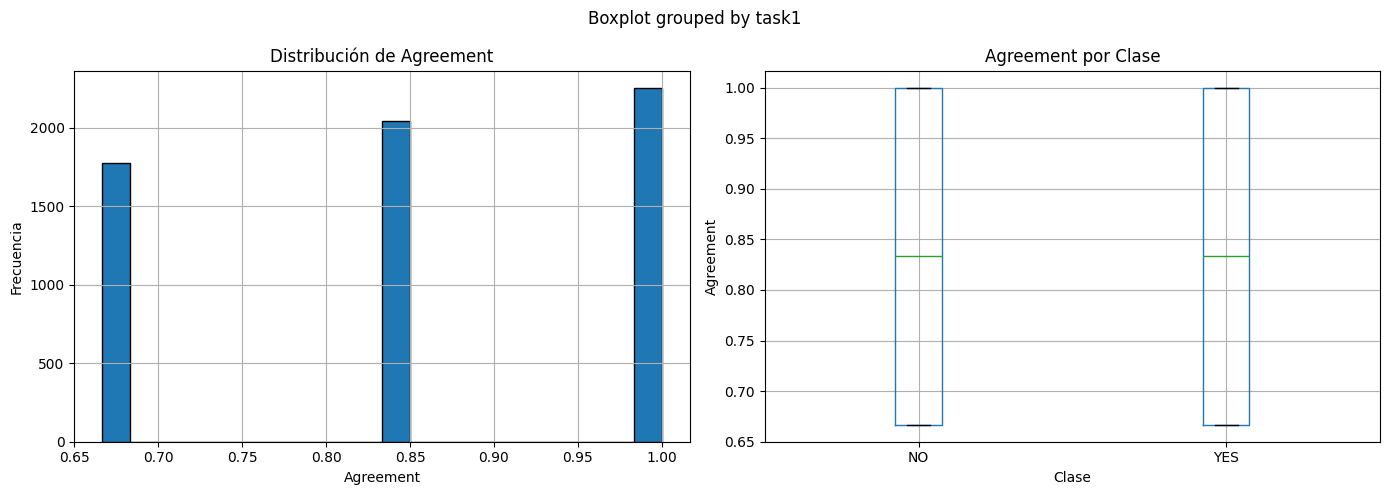


Agreement promedio: 0.846
Muestras con bajo agreement (<0.6): 0 (0.0%)


In [8]:
# Agreement vs dificultad
df['agreement'] = df['labels_task1'].apply(lambda x: Counter(x).most_common(1)[0][1] / len(x))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de agreement
df['agreement'].hist(bins=20, ax=axes[0], edgecolor='black')
axes[0].set_title('Distribución de Agreement')
axes[0].set_xlabel('Agreement')
axes[0].set_ylabel('Frecuencia')

# Agreement por clase
df.boxplot(column='agreement', by='task1', ax=axes[1])
axes[1].set_title('Agreement por Clase')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Agreement')

plt.tight_layout()
plt.show()

print(f"\nAgreement promedio: {df['agreement'].mean():.3f}")
print(f"Muestras con bajo agreement (<0.6): {(df['agreement'] < 0.6).sum()} ({(df['agreement'] < 0.6).mean()*100:.1f}%)")

## Resumen de Insights

In [9]:
print("="*60)
print("INSIGHTS CLAVE")
print("="*60)
print(f"1. Desbalance de clases: {df['task1'].value_counts()['YES']/len(df)*100:.1f}% positivos")
print(f"2. Agreement promedio: {df['agreement'].mean():.2f}")
print(f"3. Vocabulario único YES/NO: {vocab_stats.loc['YES', 'vocab_size']}/{vocab_stats.loc['NO', 'vocab_size']}")
print(f"4. Palabras más discriminativas: ver chi-square")
print(f"5. Patrones importantes: URLs, mentions, exclamations")
print("="*60)

INSIGHTS CLAVE
1. Desbalance de clases: 44.5% positivos
2. Agreement promedio: 0.85
3. Vocabulario único YES/NO: 22198.0/29449.0
4. Palabras más discriminativas: ver chi-square
5. Patrones importantes: URLs, mentions, exclamations
